# Assignment

Use the "from the expert" (FTE) jupyter notebook as a starter for this assignment, and ask your instructor questions if you need help.

Use our saved churn data from week 2 with machine learning to predict if customers will churn or not, similar to what we did in the FTE:

- break up data into features and targets
- split data into train and test sets
- use at least one ML model to fit to the training data
- evaluate performance on the train and test sets: at least evaluate accuracy and compare it with the "no information rate"
- plot a confusion matrix
- write something describing how the ML algorithm could be used in a business setting
- Write a short summary of what you did with the overall process - describe any important EDA findings, data cleaning and preparation, modeling, and evaluation in your summary.

*Optional*: For an addition challenge, try the following:
- fit more ML models and compare their scores
- optimize the hyperparameters of your models
- examine more metrics such as the classification report and ROC/AUC
- plot the distribution of the probability predictions (from the `predict_proba()` function from our model) for each class (1s and 0s)

### DS process status

Here is our data science process, and where we are (#4):

**1. Business understanding**

Can we use machine learning to predict if a customer will churn before they leave?

**2. Data understanding**

Week 1 - EDA and visualization.

**3. Data preparation**

Last week - cleaning and feature engineering.


**4. Modeling**

This week.
Fit a ML model to the data.


**5. Evaluation**

This week.
Check the performance of our models and evaluate how it fits our goals from step 1.


**6. Deployment**

This week.
Describe how the model might be deployed and used at the business. Will there be an API that customer service reps can use when customers call? Should there be a system where a report gets sent to someone in customer retention or marketing with at-risk customers? We should really think about these things in the first step, although we can consider them here this time.

### Business/Data understanding and Data preparation

Last week - cleaning and feature engineering.

In [1]:
import pandas as pd
from pandas_profiling import ProfileReport
import matplotlib.pyplot as plt

%matplotlib inline
import phik
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import plot_confusion_matrix

In [2]:
df = pd.read_csv('prepped_churn_data2.csv', index_col='customerID')

report = ProfileReport(df)
report.to_file('churn_prepped_eda.html')

df_log = pd.read_csv('prepped_logchurn_data.csv', index_col='customerID')
report = ProfileReport(df_log)
report.to_file('churn_log_eda.html')

This is the information from the clean and prepped data prepared in week 2 churn assignment. I replaced the mistaken outliers.I used KNN advanced technique from week 2 FTE. I originally only used this to deepen my understanding of the tool but on further thought, the KNN created anomalies from good data which did not need to be removed.

### Features and Targets

In [3]:
features = df.drop('Churn', axis=1)
targets = df['Churn']

### Train and Test

In [4]:
x_train, x_test, y_train, y_test = train_test_split(features, targets, stratify=targets, random_state=42)

note to self: the 42 could essentially be any number but ensures you get the same first run every time for reproducible results

### Fit ML Model

In [5]:
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(x_train, y_train)

LogisticRegression(max_iter=1000)

### Evaluation: Accuracy

In [6]:
df['Churn'].value_counts(normalize=True)

0    0.734215
1    0.265785
Name: Churn, dtype: float64

Our "no information" rate is 73% as the majority class fraction. 

In [7]:
print(lr_model.score(x_train, y_train))
print(lr_model.score(x_test, y_test))

0.7986348122866894
0.7935153583617748


Our 79% accuracy on test set is better than our "no information" rate. 
There is a very small amount of overfitting with our train model predicting .5% higher than our test model. 
I don't love the accuracy percentage. However, I am happy it is higher than with "no information" where the model predicts all customers nochurn at 73% acccuracy.

### Confusion Matrix

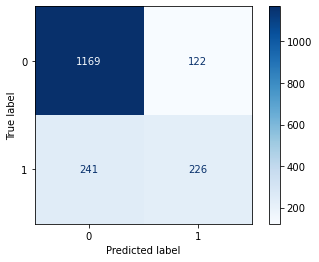

In [8]:
plcmx = plot_confusion_matrix(lr_model, x_test, y_test, cmap='Blues')
plt.show(plcmx)

* TN = 1169 Predicted No Churn, was No Churn
* TP = 226  Predicted Churn, was Churn
* FP = 122  Predicted Churn, was NoChurn
* FN = 241  Predicted No Churn, was Churn <--- I want to fix this one for greater accuracy in who actually churns and why

### Proba Predict: Improve Accuracy

TPR = TP / (TP + FN)
TPR = 48.4% (I really dont like that)

In [9]:
lr_model.predict_proba(x_test)[:5]

array([[0.47017409, 0.52982591],
       [0.96086123, 0.03913877],
       [0.51274426, 0.48725574],
       [0.34800871, 0.65199129],
       [0.90264714, 0.09735286]])

In [10]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

rf_model = RandomForestClassifier(max_depth=5, n_jobs=-1, random_state=42)
gb_model = GradientBoostingClassifier(max_depth=4, random_state=42)

rf_model.fit(x_train, y_train)
gb_model.fit(x_train, y_train)

GradientBoostingClassifier(max_depth=4, random_state=42)

In [11]:
print(rf_model.score(x_train, y_train))
print(rf_model.score(x_test, y_test))

0.8081152825180129
0.7906712172923777


Greater overfitting than before by 0.12% (still not very significant)

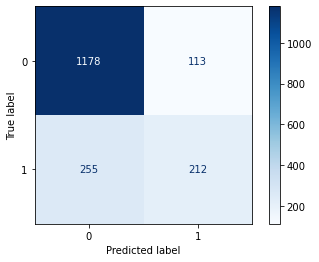

In [12]:
plt.show(plot_confusion_matrix(rf_model, x_test, y_test, cmap='Blues'))

In [13]:
print(gb_model.score(x_train, y_train))
print(gb_model.score(x_test, y_test))

0.8407281001137656
0.7895335608646189


Even greater

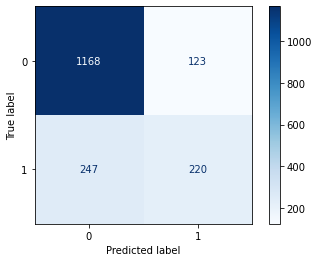

In [14]:
plt.show(plot_confusion_matrix(gb_model, x_test, y_test, cmap='Blues'))

In [15]:
lr_model.predict(x_test)[:5]

array([1, 0, 0, 1, 0], dtype=int64)

In [16]:
(lr_model.predict_proba(x_test)[:5, 1] > 0.5).astype('int')

array([1, 0, 0, 1, 0])

In [17]:
predictions_lower_threshold = (lr_model.predict_proba(x_test)[:,1]>0.155).astype(int)

In [18]:
from sklearn.metrics import accuracy_score, confusion_matrix

print(accuracy_score(y_test, predictions_lower_threshold))
tn, fp, fn, tp  = confusion_matrix(y_test, predictions_lower_threshold).flatten()
print(tp / (tp + fn))

0.6695108077360638
0.9014989293361885


By making the lower threshold 0.155 made the True Positive Rate 90% but dropped the accuracy to below the "no information" threshold. I would still like to make this more accurate. 

### Coefficients

In [19]:
lr_model.coef_

array([[-2.01413710e-02,  1.70920212e-02,  1.60287728e-04,
        -1.03208005e+00,  1.23348391e+00, -5.88071740e-01,
        -5.74542519e-01, -1.07811714e-01, -5.54766951e-01,
        -1.90252995e-02,  9.16638754e-03,  2.17241839e-02]])

In [20]:
features.columns

Index(['tenure', 'MonthlyCharges', 'TotalCharges', 'PhoneService_Yes',
       'Month-to-month', 'Bank transfer (automatic)',
       'Credit card (automatic)', 'Electronic check', 'Mailed check',
       'TotalCharges_MonthlyCharges_ratio', 'AverageMonthlyCharges',
       'MonthlyCharges_tenure_Ratio'],
      dtype='object')

In [21]:
coef_df = pd.DataFrame(data=lr_model.coef_, columns=features.columns)

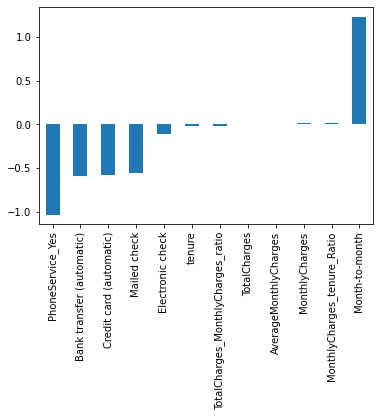

In [22]:
plt.show(coef_df.T.sort_values(by=0).plot.bar(legend=False))

In [23]:
10**1.1

12.589254117941675

Churn odds increases by a factor of 13 if the customer is in a month-to-month contract

In [24]:
10**(1)

10

Churn odds decreases by a factor of 1 when a customer is using a phone service

In [25]:
10**0.5

3.1622776601683795

Churn odds decreases by 3 under 3 independent circumstances:

* credit card or 
* bank transfer) or 
* paying by a mailed check

This tells me that customers are more likely to stay with the service it they are making automatic payments or deliberately mailing a check each month. An electronic check may involve a surcharge or a longer clearing time with the bank.

# 6. Deployment

I would deploy this model into an application programming interface (API) in which the marketing department can import customer features and the algorithm will predict whether or not the customer may churn in the next month for month-to-month customers or one-to-three months for contract customers. This timeframe will allow the company to maximize quarterly profits for the business and stakeholders. In the event the API predicts a churn the following circumstances would trigger a specific automated promotion to the customer's account and the customer can receive a written notification from the company website or mobile app, by email, mail, or text:
- If a month-to-month contract is reaching a monthly charge of \$60
    - and the customer doesn't have a phone service: 
        - offer a limited time price for qualifying bundled phone service under \$60 when signing a one-year contract
    - and the customer has a phone-service:
        - offer rebate for switching to a one or two-year contract
- If the customer is in a long-term contract:
    - offer a discounted rate when choosing to setup autopay
    - offer a rebate on their trade-in phones on their next contract renewal
    
Even if the promotional offers are sent to customers that were predicted to churn falsely they may not elect to receive the offer and if they do, the company will still retain those customers as well as those that were predicted accurately. The longer the customers stay with the company the greater the overall quarterly profits. The customers that were predicted to leave falsely may stay with the company longer than they would have without the prediction and subsequent offer.

# Summary

I fixed the prepped data from last week that removed good data as outliers. I kept the features the same as they were with the ratios, converted categorical values, and log data. I removed the two-year and one-year features because in my advanced prediction probabilities the long-term contracts were throwing off the algorithm and giving increased false negatives. From the phi-k correlation I found that the highest correlation to churn was month-to-month contracts and the average monthly prices reaching \$60 per month. I fit the data to a logarithmic regression model that shows 90\% accuracy on the test data with a majority class fraction of 67\%. I would like to find a way to make the majority test data more accurate. This will be version 1 to be implemented for a marketing API. Updated versions will show greater accuracy.